### About this analysis
* `MajorLeaguePitcher.csv` contains 2013 Major league's pitcher's stats
* 11 pitcher for 9 parameters (ERA, Win, Inning pitched etc)
  * Be careful some parameters are **smaller is better** (like ERA, BB), and some **larger is better** (like Win, SO). 
* This try to do PCA analysis for 11 pitchers on PySpark

In [1]:
import json, os, datetime, collections, commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.exists("./MajorLeaguePitcher.csv"):
    print "csv file not found at driver node, will download and copy to HDFS"
    commands.getoutput("wget -q https://raw.githubusercontent.com/taka4sato/qiita_articles/master/MajorLeaguePitcher.csv")
    commands.getoutput("hadoop fs -copyFromLocal -f ./MajorLeaguePitcher.csv /user/hadoop/")

whole_raw_log = sc.textFile("/user/hadoop/MajorLeaguePitcher.csv")

header = whole_raw_log.first()
whole_log = whole_raw_log.filter(lambda x:x !=header).map(lambda line: line.split(","))

/usr/local/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
pd_df = pd.DataFrame(whole_log.collect(),  columns=header.split(","))
pd_df2 = pd_df.iloc[:,2:]
pd_df2.index = pd_df['name'].values

pd_df3 = pd_df2.astype(float)
pd_df3

,ERA,Win,Innings pitched,OBA,HR,BB,SO,GB/FB,WHIP
Verlander,3.46,13,281.1,0.229,19,79,217,0.672,1.32
Scherzer,2.90,21,214.1,0.181,18,60,240,0.624,0.97
Hernandez,3.04,12,204.1,0.224,15,49,216,1.122,1.13
Iwakuma,2.66,14,219.2,0.206,25,44,185,1.015,1.01
Darvish,2.83,13,209.2,0.171,26,88,277,0.731,1.07
Lester,3.75,15,213.1,0.231,19,74,177,0.849,1.29
Guthrie,4.04,15,211.2,0.261,30,67,111,0.801,1.39
Kuroda,3.31,11,201.1,0.231,20,45,150,0.902,1.16
Price,3.33,10,186.2,0.241,16,30,151,0.894,1.10
Jimenez,3.30,13,182.2,0.209,16,83,194,0.831,1.33


In [3]:
#Normalize each column. (value-average)/standard_diviation
pd_df_nomalized = (pd_df3 - pd_df3.mean()) / (pd_df3.std())
pd_df_nomalized

,ERA,Win,Innings pitched,OBA,HR,BB,SO,GB/FB,WHIP
Verlander,0.460859,-0.329690,2.689063,0.408177,-0.182216,0.691177,0.557093,-1.196817,0.870629
Scherzer,-0.923967,2.307832,0.076223,-1.449732,-0.382654,-0.228925,1.058675,-1.531875,-1.506621
Hernandez,-0.577760,-0.659380,-0.313754,0.214645,-0.983967,-0.761615,0.535285,1.944352,-0.419878
Iwakuma,-1.517464,0.000000,0.275110,-0.482071,1.020411,-1.003747,-0.140760,1.197452,-1.234935
Darvish,-1.097070,-0.329690,-0.114866,-1.836797,1.220848,1.127014,1.865568,-0.784975,-0.827406
Lester,1.178002,0.329690,0.037225,0.485590,-0.182216,0.449045,-0.315224,0.038709,0.666865
Guthrie,1.895144,0.329690,-0.036870,1.646783,2.022600,0.110060,-1.754546,-0.296349,1.346079
Kuroda,0.089924,-0.989071,-0.430746,0.485590,0.018222,-0.955321,-0.904037,0.408669,-0.216114
Price,0.139382,-1.318761,-1.011811,0.872654,-0.783530,-1.681717,-0.882229,0.352826,-0.623642
Jimenez,0.065195,-0.329690,-1.167801,-0.365952,-0.783530,0.884882,0.055511,-0.086937,0.938551


In [4]:
from pyspark.ml.feature import *
from pyspark.mllib.linalg import Vectors

densevector_list = []
for normalized_pd_df_one_line in map(list, pd_df_nomalized.values):
    densevector_one_list = []
    for pd_df_item in normalized_pd_df_one_line:
        densevector_one_list.append(np.float64(pd_df_item).item())
    densevector_list.append((Vectors.dense(densevector_one_list),))

#Finally, we get Spark Dataframe with "Dense Vector"
spark_normalized_df = sqlContext.createDataFrame(densevector_list, ["features"])

In [5]:
from numpy.linalg import eigh
from pyspark.mllib.linalg import *

def estimateCovariance(df):
    m = df.select(df["features"]).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df["features"]).map(lambda x: x[0]).map(lambda x: x-m)  # subtract the mean
    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

        
def pca(df, k=2):
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvalues
    score = df.select(df["features"]).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    scoreDF = sqlContext.createDataFrame(score.map(lambda x: (DenseVector(x),)), ["pca_features"])
    return components.T, scoreDF, eigVals

        
def varianceExplained(df, k=1):
    eigenvalues = pca(df,k)[2] 
    return sum(eigenvalues[0:k])/sum(eigenvalues)

In [6]:
num_of_parameter = len(pd_df_nomalized.columns)
print "number of parameter is %d " % num_of_parameter

pca_extracted = PCA(k=num_of_parameter, inputCol="features", outputCol="pca_features")
model = pca_extracted.fit(spark_normalized_df)

# comp is numpy array object, and PCA'ed vectors (eigenvectors)
# score is RDD object, and coordinates of each sample at PCA'ed vectors
# eigVals is numpy array object, percentage of variance explained for PCA'ed vectors

comp, score, eigVals = pca(spark_normalized_df, k=num_of_parameter)
Sum_contribution = 0
for each_eigVal in eigVals:
    Sum_contribution += each_eigVal
    print Sum_contribution/sum(eigVals)

number of parameter is 9 
0.36371176745
0.642146378085
0.764435979475
0.860839933973
0.941208033888
0.987513630763
0.99777349109
0.999261752424
1.0


#### Finding from PCA's variance explained
* when reduced to 2 dimension, 64.2% of data kept.

In [7]:
num_new_dimension = 2

def corr_inter(X, Y):
  X_normed = (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)
  Y_normed = (Y - Y.mean(axis=0)) / Y.std(axis=0, ddof=0)
  return np.dot(X_normed.T, Y_normed) / X.shape[0]

#score.collect() retunrs list of "Pyspark DenseVector", thus need "tolist()"
list_PCA_score = []
for each_score in score.collect():
    list_PCA_score.append(each_score[0].tolist())

#Calculate the correlation matrix between original-score and PCA'ed score
np_PCA_score = np.array(list_PCA_score, dtype=float)
np_original_score = pd_df_nomalized.as_matrix()
np_matrixs_corr = corr_inter(np_original_score, np_PCA_score)[:,:num_new_dimension]

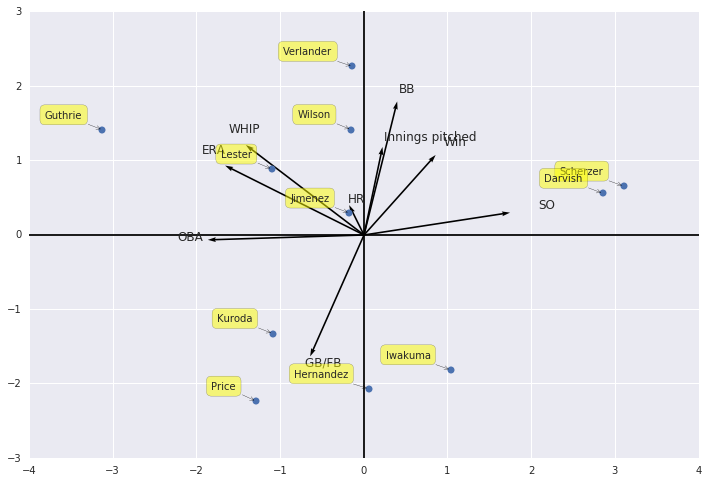

In [8]:
#Draw chart for pitcher stats as 2 dimension.

#Chart initialize and draw dots for PCA'd score
plt.figure(figsize=(12,8))
plt.plot(np_PCA_score[:,0], np_PCA_score[:,1], "o") 
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')

#Draw arrows for factor loadings (of original 9 dimensions at new 2 dimensions)
for count in range (0, len(pd_df_nomalized.columns.values)):
    x_value = np_matrixs_corr[count][0]
    y_value = np_matrixs_corr[count][1]
    plt.annotate(pd_df_nomalized.columns.values[count], xy=(2, 1), xytext=(x_value*2.3, y_value*2.3), fontsize=12)
    plt.quiver(x_value, y_value, angles='xy', units='xy', width=0.02, scale=0.5)

#Draw "annotate" for picher's name
for count in range (0, len(pd_df_nomalized.index.values)):
    plt.annotate(
        pd_df_nomalized.index.values[count], 
        xy = (np_PCA_score[:,0][count], np_PCA_score[:,1][count]), xytext = (-20, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))